# PIK3CA: Effects of Mutation on IRS2

<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [1]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [2]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#print(proteomics)

idx     A1BG     A2M    A2ML1  A4GALT      AAAS    AACS    AADAT    AAED1  \
S001 -1.1800 -0.8630 -0.80200  0.2220  0.256000  0.6650  1.28000 -0.33900   
S002 -0.6850 -1.0700 -0.68400  0.9840  0.135000  0.3340  1.30000  0.13900   
S003 -0.5280 -1.3200  0.43500     NaN -0.240000  1.0400 -0.02130 -0.04790   
S004  2.3500  2.8200 -1.47000     NaN  0.154000  0.0332  0.51300  0.67400   
S005 -1.6700 -1.1900 -0.44300  0.2430 -0.099300  0.7570  0.74000 -0.92900   
S006 -0.3740 -0.0206 -0.53700  0.3110  0.375000  0.0131 -1.10000      NaN   
S007 -1.0800 -0.7080 -0.12600 -0.4260 -0.114000 -0.1110  0.89500  1.26000   
S008 -1.3200 -0.7080 -0.80800 -0.0709  0.138000  0.6560 -0.28000 -0.12800   
S009 -0.4670  0.3700 -0.33900     NaN  0.434000  0.0358 -0.17500  0.18100   
S010 -1.1200 -1.3100  0.91200  0.4180 -0.076800  0.8460 -0.12100      NaN   
S011 -0.7160 -0.8850  2.82000 -0.3430  0.147000  0.4450 -0.05650 -0.83800   
S012 -0.2320 -0.0910  0.61800  1.6300 -0.250000  1.3300 -1.72000 -0.88900   

# PI3KCA mutation and IRS2 proteome abundance (with control)

### Perform a t-test with mutated and non-mutated protein levels

In [4]:
protList = ['IRS2']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

Test for IRS2: 
Ttest_indResult(statistic=-4.508474155013169, pvalue=1.3189412759220983e-05)


 ### We can now plot the data 

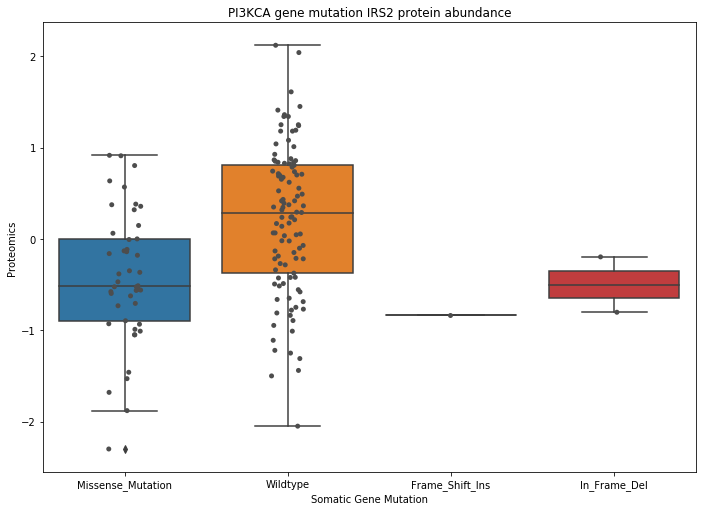

In [5]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='IRS2', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS2 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='IRS2',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS2 proteome abundance (no control)

<b> Take out the control </b>

In [6]:
proteomics = proteomics[:100]

### Perform a t-test with mutated and non-mutated protein levels

In [7]:
protList = ['IRS2']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest) 
            

Unsignificant result for IRS2: 
Ttest_indResult(statistic=-1.7027638488202286, pvalue=0.09188212411981012)


 ### We can now plot the data 

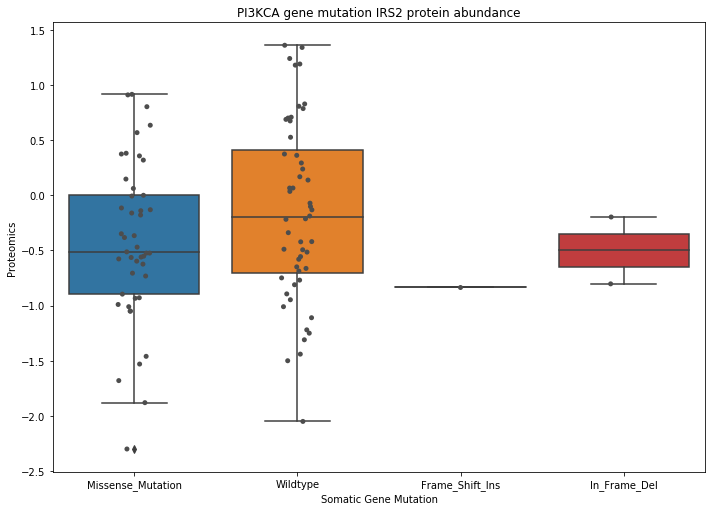

In [8]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y='IRS2', ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS2 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y='IRS2',jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS2 phosphoproteome abundance 

In [9]:
sites = phos.columns
p_values = []
site_names = []
protein = 'IRS2'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    print(phosphositesdf)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            site_names.append(site)     
                
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

      IRS2-S1100  IRS2-S1148  IRS2-S1149  IRS2-S1162  IRS2-S1174  IRS2-S1176  \
S001     -1.0000         NaN         NaN         NaN         NaN         NaN   
S002     -0.8950         NaN         NaN         NaN   -0.487000         NaN   
S003     -0.4790         NaN         NaN         NaN         NaN         NaN   
S004      0.8430         NaN         NaN         NaN    0.120000         NaN   
S005     -2.2600         NaN         NaN         NaN         NaN         NaN   
S006      0.4950         NaN         NaN         NaN         NaN     -0.2320   
S007     -0.0540         NaN         NaN         NaN   -0.287000         NaN   
S008     -0.8250         NaN      -0.391     -0.4085   -0.562000     -0.2930   
S009      0.5750         NaN         NaN         NaN    0.443000         NaN   
S010      0.8300         NaN         NaN         NaN         NaN     -0.0306   
S011     -0.3870         NaN         NaN         NaN         NaN         NaN   
S012     -1.0200         NaN      -0.812

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['IRS2-S1100' 'IRS2-S1174' 'IRS2-S391' 'IRS2-S560' 'IRS2-S577' 'IRS2-S643'
 'IRS2-S731' 'IRS2-S736' 'IRS2-S973' 'IRS2-T520']
[nan nan nan nan nan nan nan nan nan nan]
{'IRS2-S1100': nan, 'IRS2-S1174': nan, 'IRS2-S391': nan, 'IRS2-S560': nan, 'IRS2-S577': nan, 'IRS2-S643': nan, 'IRS2-S731': nan, 'IRS2-S736': nan, 'IRS2-S973': nan, 'IRS2-T520': nan}


/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [10]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

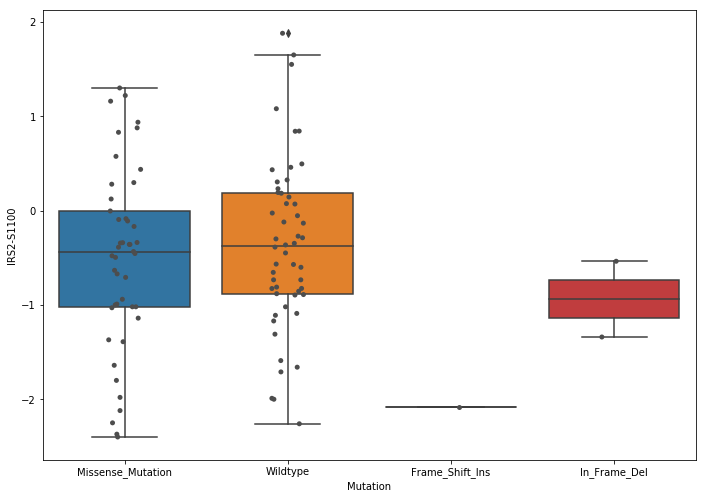

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S1100')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S1100', jitter = True, color = '.3')
plt.show()

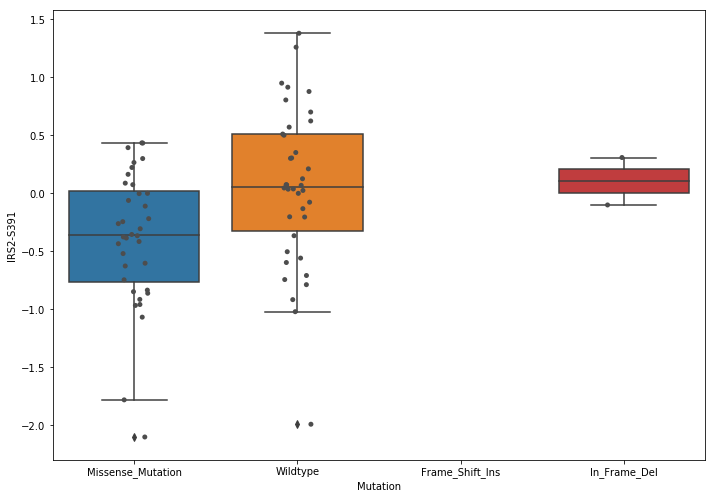

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S391')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S391', jitter = True, color = '.3')
plt.show()

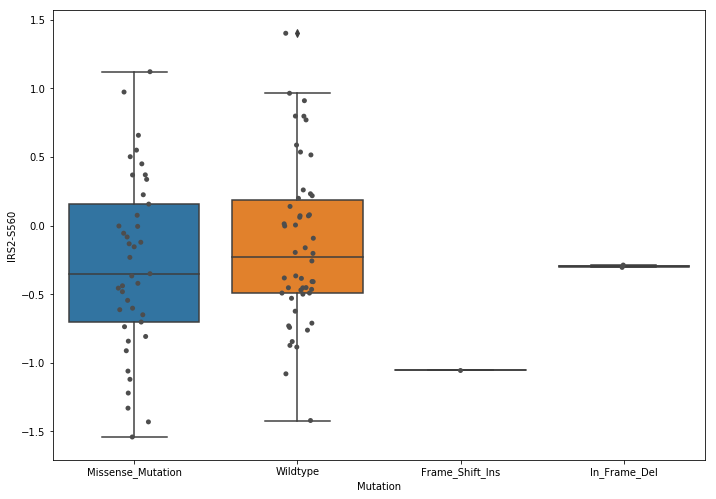

In [13]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S560')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S560', jitter = True, color = '.3')
plt.show()

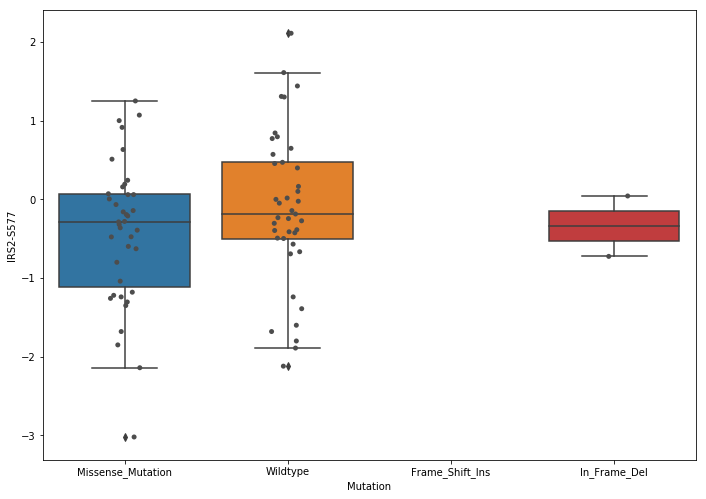

In [14]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S577')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S577', jitter = True, color = '.3')
plt.show()

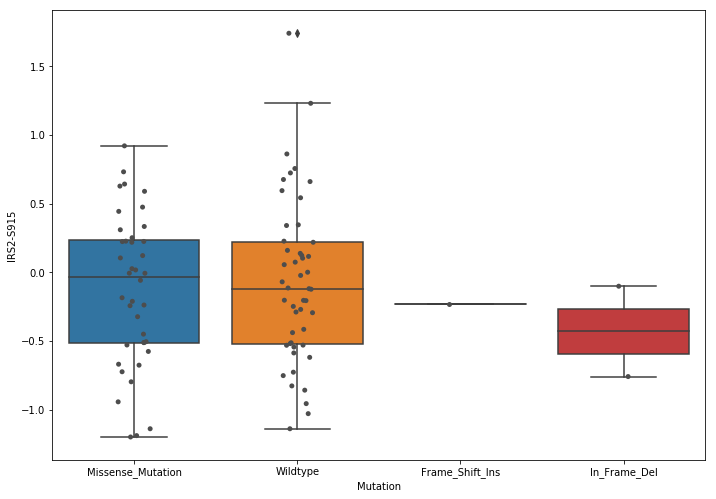

In [15]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S915')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S915', jitter = True, color = '.3')
plt.show()

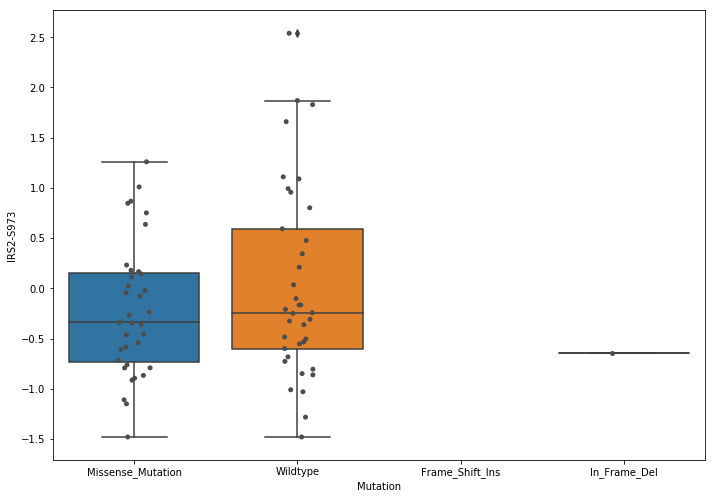

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = 'IRS2-S973')
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = 'IRS2-S973', jitter = True, color = '.3')
plt.show()

## Plot all of the statistically significant phosphoproteomic measurements

In [17]:
protein = 'IRS2'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
#print(phosdf)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [18]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]
plotdf = None

In [19]:
for site in significant_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)

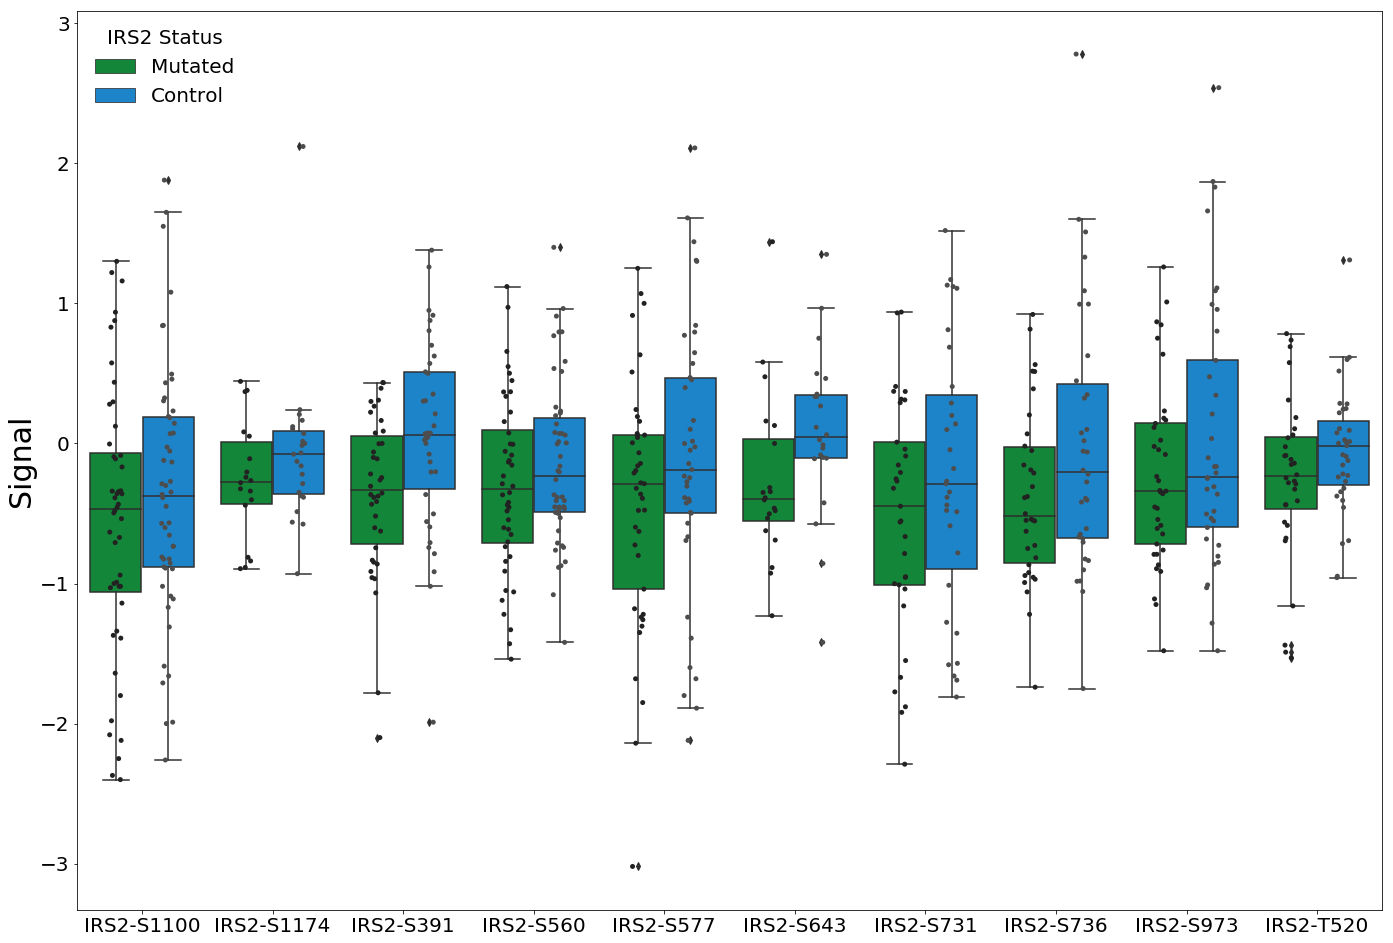

In [20]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='IRS2 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()